In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, make_scorer



In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("parisrohan/credit-score-classification")

print("Path to dataset files:", path)

100%|██████████| 9.51M/9.51M [00:00<00:00, 11.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/parisrohan/credit-score-classification/versions/1


In [3]:
# Step 1: Load Dataset
df = pd.read_csv(path + '/train.csv')


<ipython-input-3-57833999cdae>:2: DtypeWarning: Columns (26) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(path + '/train.csv')


In [4]:
df.shape

(100000, 28)

In [5]:
df

,ID,Customer_ID,Month,Name,Age,SSN,Occupation,Annual_Income,Monthly_Inhand_Salary,Num_Bank_Accounts,...,Credit_Mix,Outstanding_Debt,Credit_Utilization_Ratio,Credit_History_Age,Payment_of_Min_Amount,Total_EMI_per_month,Amount_invested_monthly,Payment_Behaviour,Monthly_Balance,Credit_Score
0,0x1602,CUS_0xd40,January,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,_,809.98,26.822620,22 Years and 1 Months,No,49.574949,80.41529543900253,High_spent_Small_value_payments,312.49408867943663,Good
1,0x1603,CUS_0xd40,February,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.944960,NaN,No,49.574949,118.28022162236736,Low_spent_Large_value_payments,284.62916249607184,Good
2,0x1604,CUS_0xd40,March,Aaron Maashoh,-500,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,28.609352,22 Years and 3 Months,No,49.574949,81.699521264648,Low_spent_Medium_value_payments,331.2098628537912,Good
3,0x1605,CUS_0xd40,April,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,NaN,3,...,Good,809.98,31.377862,22 Years and 4 Months,No,49.574949,199.4580743910713,Low_spent_Small_value_payments,223.45130972736786,Good
4,0x1606,CUS_0xd40,May,Aaron Maashoh,23,821-00-0265,Scientist,19114.12,1824.843333,3,...,Good,809.98,24.797347,22 Years and 5 Months,No,49.574949,41.420153086217326,High_spent_Medium_value_payments,341.48923103222177,Good
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0x25fe9,CUS_0x942c,April,Nicks,25,078-73-5990,Mechanic,39628.99,3359.415833,4,...,_,502.38,34.663572,31 Years and 6 Months,No,35.104023,60.97133255718485,High_spent_Large_value_payments,479.866228,Poor
99996,0x25fea,CUS_0x942c,May,Nicks,25,078-73-5990,Mechanic,39628.99,3359.415833,4,...,_,502.38,40.565631,31 Years and 7 Months,No,35.104023,54.18595028760385,High_spent_Medium_value_payments,496.65161,Poor
99997,0x25feb,CUS_0x942c,June,Nicks,25,078-73-5990,Mechanic,39628.99,3359.415833,4,...,Good,502.38,41.255522,31 Years and 8 Months,No,35.104023,24.02847744864441,High_spent_Large_value_payments,516.809083,Poor
99998,0x25fec,CUS_0x942c,July,Nicks,25,078-73-5990,Mechanic,39628.99,3359.415833,4,...,Good,502.38,33.638208,31 Years and 9 Months,No,35.104023,251.67258219721603,Low_spent_Large_value_payments,319.164979,Standard


In [6]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=4b8b11727d126a99dbe554a00a4e7fb08241f93ab163b5ee9f31aee0a8084631
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime


In [7]:
!pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.7/85.7 kB 8.6 MB/s eta 0:00:00


In [8]:
import shap
from lime.lime_tabular import LimeTabularExplainer

from sklearn.preprocessing import LabelEncoder
import category_encoders as ce

In [9]:
df = df.drop(columns=[
    'ID', 'Customer_ID', 'Name', 'SSN'
])

le = LabelEncoder()
df['Credit_Score'] = le.fit_transform(df['Credit_Score'])

one_hot_cols = ['Month', 'Occupation', 'Payment_of_Min_Amount', 'Payment_Behaviour']
df = pd.get_dummies(df, columns=one_hot_cols, drop_first=True)

credit_mix_map = {'Bad': 0, 'Standard': 1, 'Good': 2, 'Excellent': 3}
df['Credit_Mix'] = df['Credit_Mix'].map(credit_mix_map)

target_encoder = ce.TargetEncoder()
df['Type_of_Loan'] = target_encoder.fit_transform(df['Type_of_Loan'], df['Credit_Score'])


df = df.fillna(df.mean(numeric_only=True))

def convert_credit_age(val):
    try:
        years = int(val.split(" ")[0])
        months = int(val.split(" ")[3])
        return years * 12 + months
    except:
        return None

df['Credit_History_Age'] = df['Credit_History_Age'].apply(convert_credit_age)

In [10]:
object_cols = df.select_dtypes(include='object').columns
print(object_cols)
for col in object_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')


Index(['Age', 'Annual_Income', 'Num_of_Loan', 'Num_of_Delayed_Payment',
       'Changed_Credit_Limit', 'Outstanding_Debt', 'Amount_invested_monthly',
       'Monthly_Balance'],
      dtype='object')


In [11]:

# Step 3: Feature Selection - Chi-Square
X = df.drop('Credit_Score', axis=1)
y = df['Credit_Score']

In [12]:
for col in X.columns:
    if X[col].dtype in ['float64', 'int64']:
        X[col].fillna(X[col].median(), inplace=True)
    else:
        X[col].fillna(X[col].mode()[0], inplace=True)

y.fillna(y.mode()[0], inplace=True)

<ipython-input-12-8c83a6e02682>:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  X[col].fillna(X[col].median(), inplace=True)
<ipython-input-12-8c83a6e02682>:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'd

In [13]:

# Step 4: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.34, random_state=42)


In [14]:
# Step 5: Train Classifiers
from xgboost import XGBClassifier

# Train the XGBoost model
XGB = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    n_estimators=200,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    gamma=1,
    reg_alpha=0.5,
    reg_lambda=1.0,
    random_state=42
)
XGB.fit(X_train, y_train)



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [18:58:11] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=1, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=4,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)

In [16]:
# Step 6: Predictions and Evaluation Function
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score, roc_auc_score

y_pred = XGB.predict(X_test)
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:\n", cm)

# Specify multi_class parameter for roc_auc_score
auc = roc_auc_score(y_test, XGB.predict_proba(X_test), multi_class='ovr')  # or 'ovo'
print(f"AUC: {auc:.2f}")
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")

              precision    recall  f1-score   support

           0       0.64      0.66      0.65      6037
           1       0.78      0.75      0.77      9903
           2       0.79      0.80      0.79     18060

    accuracy                           0.76     34000
   macro avg       0.74      0.74      0.74     34000
weighted avg       0.76      0.76      0.76     34000

Confusion Matrix:
 [[ 4001   152  1884]
 [  463  7445  1995]
 [ 1770  1892 14398]]
AUC: 0.90
Accuracy: 0.76


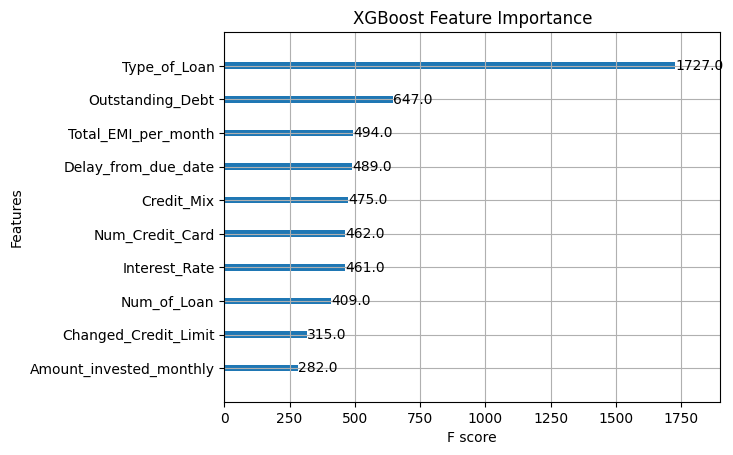

In [ ]:
import matplotlib.pyplot as plt
from xgboost import XGBClassifier, plot_importance
from sklearn.inspection import PartialDependenceDisplay
# Feature Importance
plot_importance(XGB, max_num_features=10)
plt.title("XGBoost Feature Importance")
plt.show()

In [ ]:
print(le.classes_)


['Good' 'Poor' 'Standard']


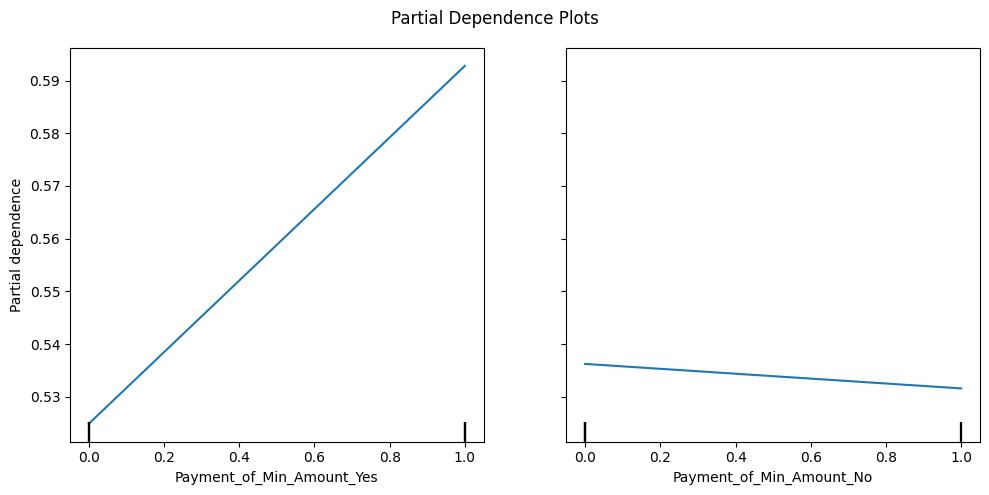

In [ ]:
# Partial Dependence Plot
top_features = np.argsort(XGB.feature_importances_)[-2:]
fig, ax = plt.subplots(figsize=(10, 5))
PartialDependenceDisplay.from_estimator(XGB, X_train, features=top_features, ax=ax, target=2)
plt.suptitle("Partial Dependence Plots")
plt.tight_layout()
plt.show()

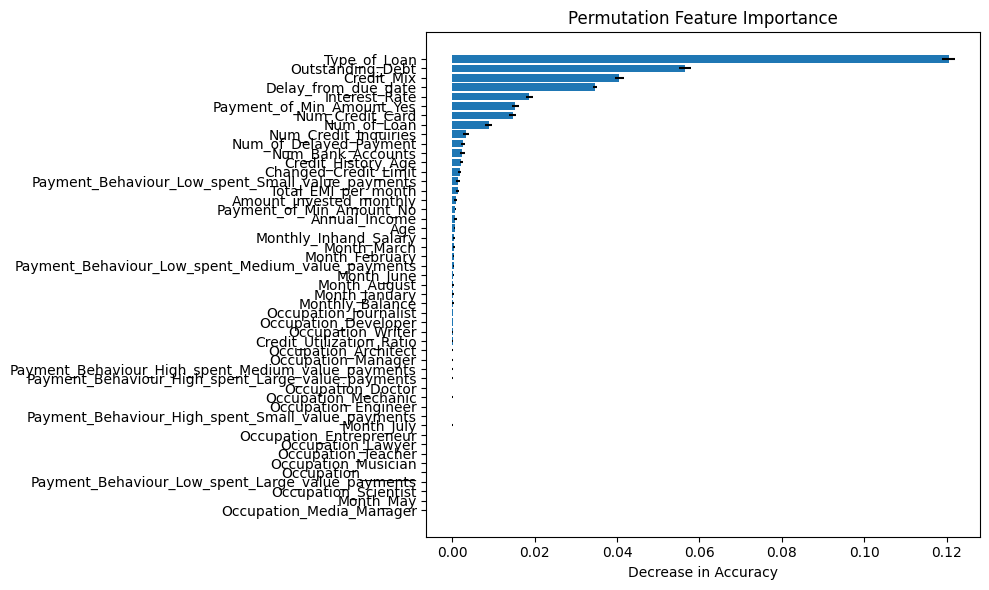

In [ ]:
from sklearn.inspection import permutation_importance

# Evaluate permutation importance
results = permutation_importance(XGB, X_test, y_test, scoring='accuracy', n_repeats=10, random_state=42)

# Get feature names from X_train columns
feature_names = X_train.columns  # Assign feature names here

# Convert to DataFrame
perm_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance Mean': results.importances_mean,
    'Importance Std': results.importances_std
}).sort_values(by='Importance Mean', ascending=False)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(perm_df['Feature'], perm_df['Importance Mean'], xerr=perm_df['Importance Std'])
plt.xlabel("Decrease in Accuracy")
plt.title("Permutation Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [ ]:
import lime
feature_names = X_train.columns  # Assign feature names here

# LIME
explainer_lime = lime.lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=feature_names,
    class_names=["No Default", "Default"],
    mode='classification'
)


i = 0  # index of test sample
exp = explainer_lime.explain_instance(X_test.iloc[i], XGB.predict_proba, num_features=5)
exp.show_in_notebook()

/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/discretize.py:110: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  ret[feature] = int(self.lambdas[feature](ret[feature]))
/usr/local/lib/python3.11/dist-packages/lime/lime_tabular.py:544: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.

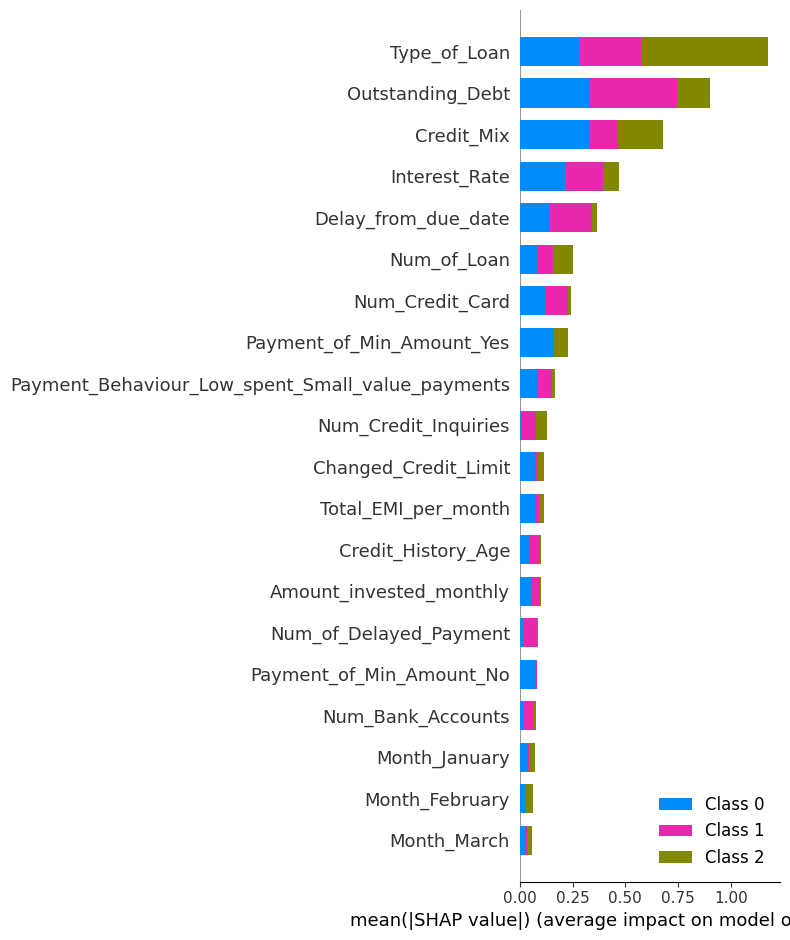

In [23]:
import shap

explainer = shap.Explainer(XGB)

# Use a subset
sample_X = X_train.sample(500, random_state=42)
shap_values = explainer(sample_X)


# Plot summary of feature importance
shap.summary_plot(shap_values, X_train)


